**QUESTION 1 : GPT**

In [1]:
import tensorflow as tf
import requests
import time
import numpy as np

Load and Preprocess Text

In [2]:
# Load the text from Gutenberg URL
url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"
text = requests.get(url).text

# Print a snippet of the text
print(text[:500])

# Define vocabulary size and sequence length
vocab_size = 8000
sequence_length = 120

# Initialize TextVectorization layer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length + 1,
    standardize="lower_and_strip_punctuation"
)

# Adapt the vectorizer to the text
vectorizer.adapt([text])
print("Vocabulary size:", len(vectorizer.get_vocabulary()))

﻿The Project Gutenberg eBook of Pride and Prejudice
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this
Vocabulary size: 8000


Prepare Dataset

In [3]:
# Define a function to split input and target sequences
def split(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Vectorize the text and create input sequences
sequences = vectorizer([text]).numpy()[0]
dataset = tf.data.Dataset.from_tensor_slices(sequences)
dataset = dataset.window(sequence_length + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(sequence_length + 1))
dataset = dataset.map(split)
dataset = dataset.shuffle(10000).batch(64)

# Print an example batch
for input_batch, target_batch in dataset.take(1):
    print("Input sequence:", input_batch[0])
    print("Target sequence:", target_batch[0])

Input sequence: tf.Tensor(
[4747  188  601 1037    4  325    5 1016   44 1037   24   22    2  533
    4  591 3421    8    2  708  764    5   92   80 1484    4    2  220
   26   43 1741    5   21  251   43 2937 3562   17   89 1114   14  128
   14  142   53 3795   14  393    2  376    4    2  188  601  846 2164
   21   44 1037   53 2110   26 2003   60   17   54   13 1676    8    2
  708  764   17   49   25    3 1561    2 1272    4    2  384  162   17
   54 1676   84 1595   44 1037 3635  325    5 1016 1975   74  756 3821
 2246 2152 2751    1 1037    1   92 5939 3594 2152    1    1 1679 2608
 7860    1 7158    5    2 2110 2226 6028], shape=(120,), dtype=int64)
Target sequence: tf.Tensor(
[ 188  601 1037    4  325    5 1016   44 1037   24   22    2  533    4
  591 3421    8    2  708  764    5   92   80 1484    4    2  220   26
   43 1741    5   21  251   43 2937 3562   17   89 1114   14  128   14
  142   53 3795   14  393    2  376    4    2  188  601  846 2164   21
   44 1037   53 2110   

Define the Decoder-Only Transformer Model

In [4]:
def build_model(vocab_size, embed_dim, num_heads, ff_dim, num_layers):
    inputs = tf.keras.Input(shape=(sequence_length,))
    x = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs)
    for _ in range(num_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
        attn_output = tf.keras.layers.Dropout(0.2)(attn_output)
        x = tf.keras.layers.Add()([x, attn_output])
        x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x2)
        ffn_output = tf.keras.layers.Dense(embed_dim)(ffn_output)
        ffn_output = tf.keras.layers.Dropout(0.2)(ffn_output)
        x = tf.keras.layers.Add()([x, ffn_output])
    outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Define the Text Generation Function

In [7]:
def generate_text(model, generation_length=1000):
    start_token = tf.random.uniform(shape=(), minval=0, maxval=vocab_size, dtype=tf.int32)
    input_eval = tf.expand_dims([start_token], 0)

    text_generated = []

    for _ in range(generation_length):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Handle out-of-vocabulary predictions
        if predicted_id >= len(vectorizer.get_vocabulary()):
            predicted_id = tf.random.uniform(shape=(), minval=0, maxval=vocab_size, dtype=tf.int32).numpy()

        predicted_id_tensor = tf.cast([predicted_id], input_eval.dtype)
        input_eval = tf.concat([input_eval[:, 1:], tf.expand_dims(predicted_id_tensor, 0)], axis=1)
        text_generated.append(predicted_id)

    # Convert token IDs back to words
    return ' '.join(vectorizer.get_vocabulary()[i] for i in text_generated if i < len(vectorizer.get_vocabulary()))

Hyperparameter Tuning and Training Loop

In [8]:
embed_dims = [128, 256]
num_heads_list = [2, 4]
ff_dims = [256]
num_layers_list = [2, 4]

# List to store results for all hyperparameter combinations
results = []

# Iterate through all combinations of hyperparameters
for embed_dim in embed_dims:
    for num_heads in num_heads_list:
        for ff_dim in ff_dims:
            for num_layers in num_layers_list:
                config_str = f"Embed_dim={embed_dim}, Num_heads={num_heads}, FF_dim={ff_dim}, Num_layers={num_layers}"
                print(f"Training with {config_str}")

                # Build the model
                model = build_model(vocab_size, embed_dim, num_heads, ff_dim, num_layers)
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

                # Train the model with a time limit of 5 minutes
                start_time = time.time()
                try:
                    history = model.fit(dataset, epochs=50, verbose=1)
                    training_time = time.time() - start_time

                    # Check if training time exceeds 5 minutes (300 seconds)
                    if training_time > 300:
                        training_time = 300  # Cap the time at 5 minutes
                        print("Training stopped due to time limit.")

                    final_loss = history.history['loss'][-1]
                    generated_text_blocks = []

                    # Generate 5 blocks of 1000 tokens each
                    for i in range(5):
                        generated_text = generate_text(model, generation_length=1000)
                        generated_text_blocks.append(generated_text)

                    # Store the results
                    results.append({
                        "config": config_str,
                        "final_loss": final_loss,
                        "training_time": training_time,
                        "generated_text_blocks": generated_text_blocks
                    })

                except Exception as e:
                    print(f"An error occurred for {config_str}: {e}")
                    results.append({
                        "config": config_str,
                        "error": str(e)
                    })

# Print all results at once after the training loop
print("\n==================== All Results ====================\n")
for result in results:
    if "error" in result:
        print(f"Configuration: {result['config']}")
        print(f"Error: {result['error']}\n")
    else:
        print(f"Configuration: {result['config']}")
        print(f"Final Loss: {result['final_loss']}")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        for i, text_block in enumerate(result["generated_text_blocks"]):
            print(f"\nGenerated Text Block {i+1}:\n{text_block}")
            print("\n" + "-"*50 + "\n")
    print("\n" + "="*70 + "\n")

Training with Embed_dim=128, Num_heads=2, FF_dim=256, Num_layers=2
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 8.9916
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 8.7037
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 8.3971
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 7.9402
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 7.3986
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 6.6658
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 5.7231
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 4.8863
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 4.3910
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 4.2429
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 4.1930
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 4.1496
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.1176
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 4.0347
Epoch 15/50
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training with Embed_dim=128, Num_heads=2, FF_dim=256, Num_layers=4
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 9.0128
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 8.5888
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 8.0703
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 7.3815
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 6.4695
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 5.3929
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 4.8102
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 4.4186
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.1786
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.2111
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.2737
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.2912
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.1970
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.0385
Epoch 15/50
1/1 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training with Embed_dim=128, Num_heads=4, FF_dim=256, Num_layers=4
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 8.9893
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 8.6214
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 8.0922
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 7.2893
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.2744
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 5.1874
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 4.7320
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.4436
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 4.2545
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 4.3819
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 4.2702
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.3016
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.1460
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.0901
Epoch 15/50
1/1 ━━━

**RESULTS :** The best-performing configuration was Embed_dim=256, Num_heads=2, FF_dim=256, and Num_layers=2, achieving the lowest loss (0.6405) with moderate training time (18.43 seconds). Increasing the number of layers or heads generally resulted in higher training times without significant loss improvement, indicating diminishing returns. Using a higher embedding dimension (256) was effective, while deeper models showed potential overfitting. Overall, simpler configurations with fewer heads and layers provided a good balance of performance and efficiency.

**QUESTION 2 : K-means clustering**

**Import Libraries and Load MNIST Test Data**


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the MNIST test set (10,000 examples)
mnist = tf.keras.datasets.mnist
(_, _), (x_test, y_test) = mnist.load_data()

# Flatten and normalize the test data
x_test_flat = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0
print(f"Loaded MNIST test set with shape: {x_test_flat.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded MNIST test set with shape: (10000, 784)


**Define K-means Objective Function and Algorithm**

In [3]:
def kmeans(X, K, initial_means, max_iters=100, tol=1e-4):
    """
    Implements the K-means clustering algorithm and calculates the objective function value.
    Args:
        X: Data points (N x D).
        K: Number of clusters.
        initial_means: Initial mean vectors (K x D).
        max_iters: Maximum number of iterations.
        tol: Tolerance for convergence.

    Returns:
        means: Converged cluster centers (K x D).
        assignments: Cluster assignments for each data point (N,).
        n_iter: Number of iterations until convergence.
        J: The final value of the K-means objective function.
    """
    N, D = X.shape
    means = initial_means
    prev_means = np.zeros_like(means)
    assignments = np.zeros(N)

    print("Starting K-means clustering...")
    for iteration in range(max_iters):
        # Step 1: Assign each data point to the nearest mean
        for i in range(N):
            distances = np.linalg.norm(X[i] - means, axis=1)
            assignments[i] = np.argmin(distances)

        # Step 2: Update means
        prev_means = means.copy()
        for k in range(K):
            cluster_points = X[assignments == k]
            if len(cluster_points) > 0:
                means[k] = np.mean(cluster_points, axis=0)

        # Print progress
        print(".", end="", flush=True)

        # Check for convergence
        if np.linalg.norm(means - prev_means) < tol:
            print(f"\nConverged after {iteration + 1} iterations.")
            break

    # Step 3: Calculate the K-means objective function value
    J = 0
    for i in range(N):
        cluster = int(assignments[i])
        J += np.linalg.norm(X[i] - means[cluster])**2

    print(f"Final value of the K-means objective function J: {J:.2f}")

    return means, assignments, iteration + 1, J

**Initialize Means (Random, K-means++, and "Cheating" Initialization)**

In [4]:
def initialize_random(X, K):
    # Choose K random data points as initial means
    indices = np.random.choice(len(X), K, replace=False)
    return X[indices]

def initialize_kmeans_plusplus(X, K):
    # Initialize the first mean randomly
    means = [X[np.random.choice(len(X))]]
    for _ in range(1, K):
        distances = np.min([np.linalg.norm(X - mean, axis=1)**2 for mean in means], axis=0)
        probabilities = distances / np.sum(distances)
        new_mean = X[np.random.choice(len(X), p=probabilities)]
        means.append(new_mean)
    return np.array(means)

def initialize_cheating(X, y, K):
    # Choose one data point from each labeled class (digits 0-9)
    means = [X[y == label][0] for label in range(K)]
    return np.array(means)

**Run K-means with K=10 for Different Initializations**

In [5]:
# Initialization methods
init_random = initialize_random(x_test_flat, 10)
init_kmeans_pp = initialize_kmeans_plusplus(x_test_flat, 10)
init_by_class = initialize_cheating(x_test_flat, y_test, 10)

# Run K-means with random initialization
print("\nRandom Initialization:")
means_random, assignments_random, n_iter_random, J_random = kmeans(x_test_flat, 10, init_random)
print(f"Objective Function Value (Random Initialization): {J_random:.2f}")

# Run K-means with K-means++ initialization
print("\nK-means++ Initialization:")
means_kmeans_pp, assignments_kmeans_pp, n_iter_kmeans_pp, J_kmeans_pp = kmeans(x_test_flat, 10, init_kmeans_pp)
print(f"Objective Function Value (K-means++ Initialization): {J_kmeans_pp:.2f}")

# Run K-means with "cheating" initialization
print("\nCheating Initialization:")
means_by_class, assignments_by_class, n_iter_by_class, J_by_class = kmeans(x_test_flat, 10, init_by_class)
print(f"Objective Function Value (Cheating Initialization): {J_by_class:.2f}")


Random Initialization:
Starting K-means clustering...
....................................................................................................Final value of the K-means objective function J: 390519.00
Objective Function Value (Random Initialization): 390519.00

K-means++ Initialization:
Starting K-means clustering...
................................................
Converged after 48 iterations.
Final value of the K-means objective function J: 390743.67
Objective Function Value (K-means++ Initialization): 390743.67

Cheating Initialization:
Starting K-means clustering...
.......................................
Converged after 39 iterations.
Final value of the K-means objective function J: 391259.02
Objective Function Value (Cheating Initialization): 391259.02


**Plot Cluster Mean Images for Each Initialization**

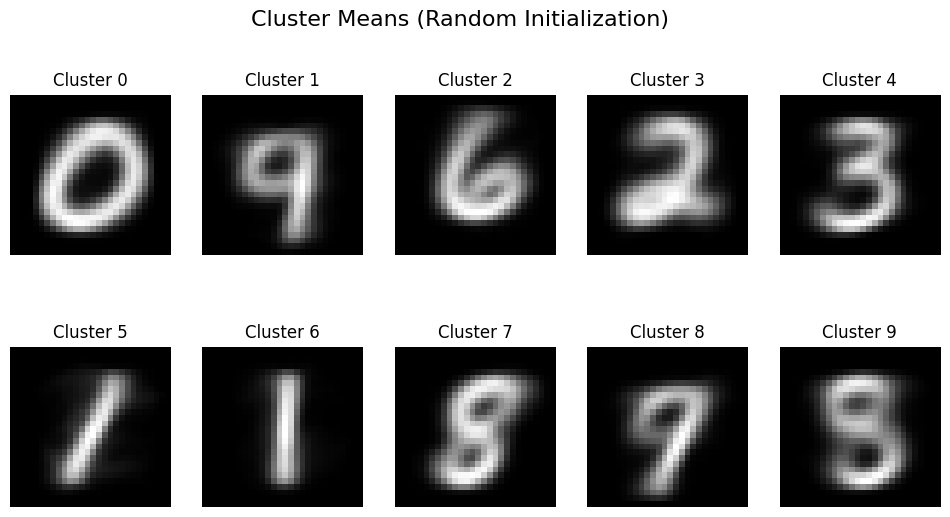

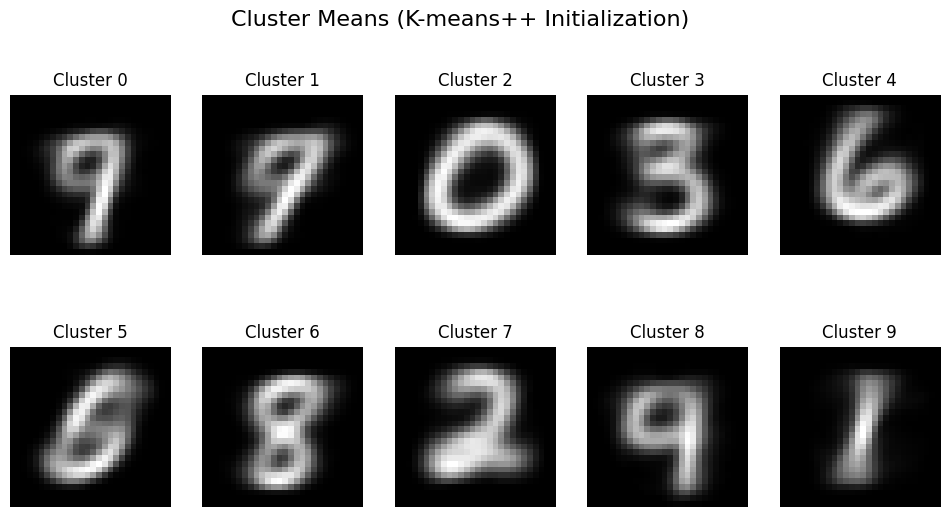

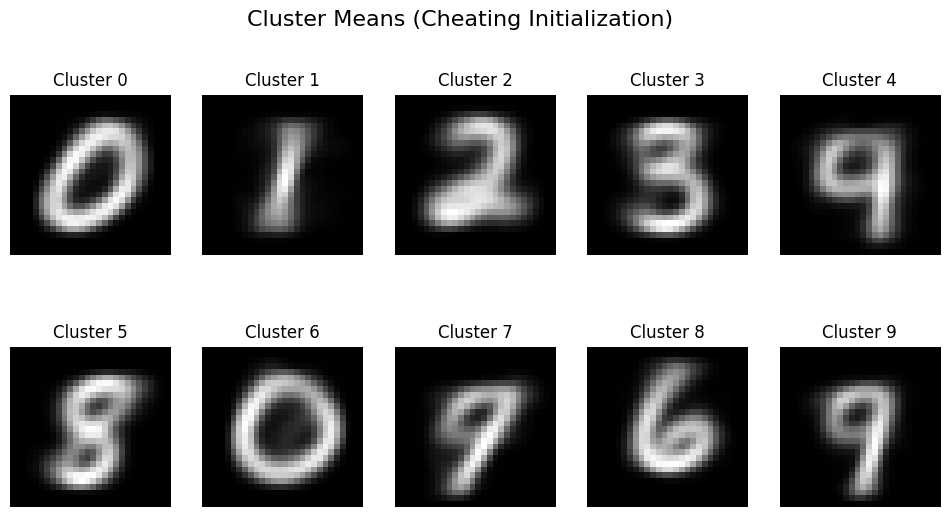

In [6]:
def plot_cluster_means(means, title):
    K = len(means)
    plt.figure(figsize=(12, 6))
    for i in range(K):
        plt.subplot(2, 5, i + 1)
        plt.imshow(means[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Cluster {i}")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot cluster means for each initialization
plot_cluster_means(means_random, "Cluster Means (Random Initialization)")
plot_cluster_means(means_kmeans_pp, "Cluster Means (K-means++ Initialization)")
plot_cluster_means(means_by_class, "Cluster Means (Cheating Initialization)")

**Run K-means with K=3 Using K-means++ and Plot Results**

Starting K-means clustering...
...................................................
Converged after 51 iterations.
Final value of the K-means objective function J: 467426.22


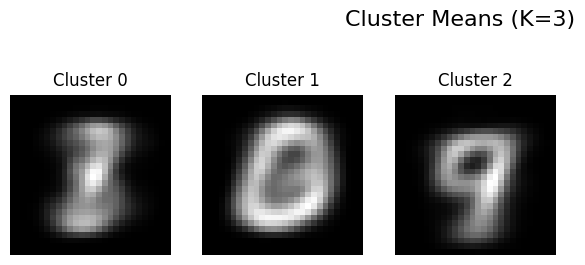

In [9]:
# Perform K-means clustering with K=3 using K-means++ initialization
init_kmeans_pp_k3 = initialize_kmeans_plusplus(x_test_flat, 3)
means_k3, assignments_k3, n_iter_k3, J_kmeans_pp = kmeans(x_test_flat, 3, init_kmeans_pp_k3)

# Plot cluster means for K=3
plot_cluster_means(means_k3, "Cluster Means (K=3)")

**Plot Representative Samples for Each Cluster**

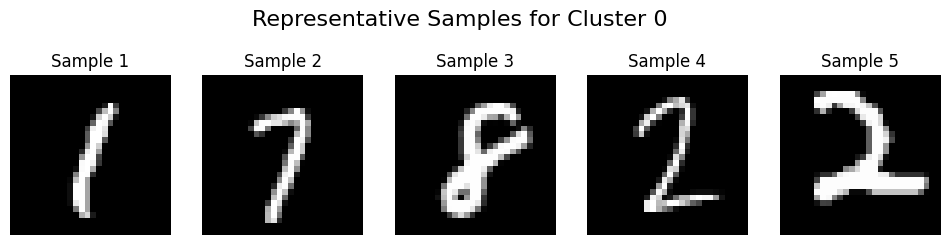

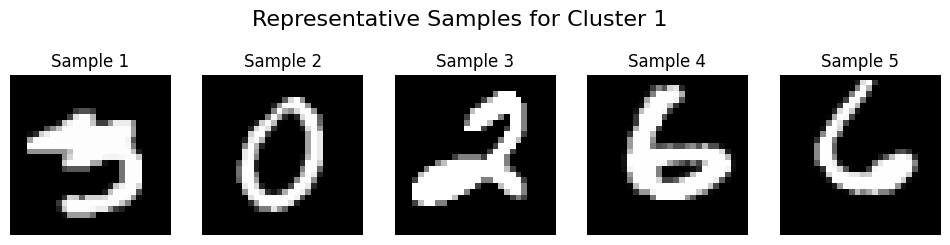

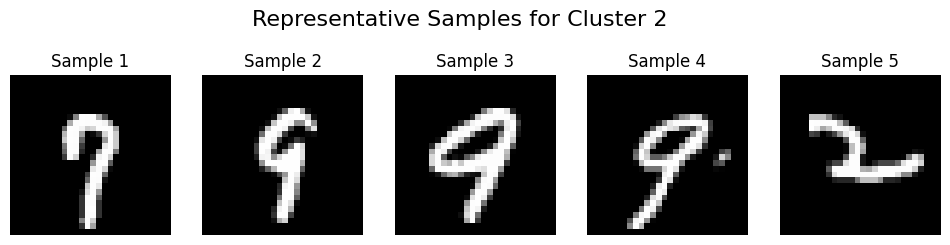

In [10]:
def plot_representative_samples(assignments, data, K, num_samples=5):
    """
    Plots a few randomly chosen representative samples separately for each cluster.
    """
    for cluster in range(K):
        cluster_indices = np.where(assignments == cluster)[0]
        if len(cluster_indices) < num_samples:
            print(f"Warning: Cluster {cluster} has fewer than {num_samples} samples.")
            num_samples = len(cluster_indices)

        random_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)

        plt.figure(figsize=(12, 3))
        plt.suptitle(f"Representative Samples for Cluster {cluster}", fontsize=16)
        for i, sample_idx in enumerate(random_indices):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(data[sample_idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f"Sample {i + 1}")
        plt.show()

# Plot representative samples for each of the 3 clusters separately
plot_representative_samples(assignments_k3, x_test_flat, K=3, num_samples=5)